In [662]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import dtreeviz

from tqdm import tqdm
import warnings
from pprint import pprint

warnings.filterwarnings("ignore")

In [663]:
data = pd.read_csv("./data/augmented_data.csv")

In [664]:
data.nunique()

period                     5
minute                   139
possession               290
duration               77925
season_id                 41
match_id                3312
timestamp              82726
team                     288
play_pattern               9
position                  25
location_x               635
location_x_distance      635
location_y               701
location_y_distance      471
technique                  7
body_part                  4
type                       5
is_penalty                 2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11897
pass_angle             10504
pass_type                  8
pass_height                4
pass_length             9918
num_passes                13
defenders_3m_radius       10
defenders_triangle        13
shooting_range         43794
best_distance          30176
goalkeeper_x  

In [665]:
# Use mutual_info classification to check which features yield the most information about the target variable
data_copy = data.copy()
X = data_copy.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "location_x", "location_y", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height", "season_id", "match_id", "timestamp", "team"], axis=1)
mutual_info = mutual_info_classif(X, data["is_goal"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

distance_to_goalie     0.058809
shooting_range         0.053107
best_distance          0.048200
defenders_triangle     0.038643
location_x_distance    0.034785
goalkeeper_x           0.028605
location_y_distance    0.023705
goalkeeper_y           0.023152
duration               0.021831
defenders_3m_radius    0.020221
is_penalty             0.016234
shot_angle             0.012691
open_goal              0.012024
pass_length            0.011525
pass_duration          0.009723
period                 0.009593
good_foot              0.007137
num_passes             0.007042
was_leading            0.005692
one_on_one             0.005043
first_time             0.004570
under_pressure         0.003595
game_state             0.003551
minute                 0.002964
possession             0.002122
pass_angle             0.001548
xg_so_far              0.001459
follows_dribble        0.001206
shots_so_far           0.000570
aerial_won             0.000000
dtype: float64

In [666]:
# drop redundant features
data.drop(["location_x", "location_y", "game_state", "body_part"], axis=1, inplace=True)
# drop features that leak target information
data.drop(["shot_angle", "duration", "season_id", "match_id", "timestamp", "team"], axis=1, inplace=True)
# drop low information features
data.drop(["aerial_won", "follows_dribble", "possession", "minute", "period", "num_passes", "pass_duration", "pass_height", "pass_type", "pass_angle", "type", "shots_so_far", "xg_so_far"], axis=1, inplace=True)
# drop penalties
data = data[data["is_penalty"] == False]

In [667]:
data.nunique()

play_pattern               9
position                  25
location_x_distance      635
location_y_distance      471
technique                  7
body_part                  4
is_penalty                 1
first_time                 2
open_goal                  2
one_on_one                 2
under_pressure             2
pass_length             9918
defenders_3m_radius        9
defenders_triangle        12
shooting_range         43788
best_distance          30176
goalkeeper_x             258
goalkeeper_y             355
distance_to_goalie     45441
statsbomb_xg           82416
end_location_x           375
end_location_y           704
is_goal                    2
good_foot                  2
was_leading                3
dtype: int64

In [668]:
# one-hot encode the categorical data
encoded_data = data
for column_name in ["play_pattern", "technique", "position"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
data = encoded_data

In [669]:
data = data.dropna()
data.replace([np.inf, -np.inf], 0, inplace=True)

In [670]:
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]
X = data.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y"], axis=1)

In [671]:
def preprocess_continuous(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    return X_train, X_test, y_train, y_test

In [672]:
def preprocess_classifier(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    X_train, y_train = SMOTE(sampling_strategy=0.30).fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [673]:
def calculate_errors(results_test, results_pred, name):
    mae = mean_absolute_error(results_test, results_pred)
    rmse = root_mean_squared_error(results_test, results_pred)
    r2 = r2_score(results_test, results_pred)
    print(f"\n{name}")
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    print("R-squared (R2 Score):", r2)

In [674]:
def calculate_stats(results_test, results_pred, name):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not a goal", "Goal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    accuracy = accuracy_score(results_test, results_pred)
    precision = precision_score(results_test, results_pred)
    recall = recall_score(results_test, results_pred)
    f1 = f1_score(results_test, results_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

In [675]:
def linear_regression():
    linear_r = LinearRegression()
    linear_r.fit(X_train, y_train)
    y_pred = linear_r.predict(X_test)

    calculate_errors(y_test, y_pred, "Linear Regression")

    return y_pred

In [676]:
def logistic_regression():
    logistic_r = LogisticRegression()
    logistic_r.fit(X_train, y_train)
    y_pred = logistic_r.predict(X_test)

    calculate_stats(y_test, y_pred, "Logistic Regression")

    return logistic_r.predict_proba(X_test)

In [677]:
def decision_tree():
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=16, max_leaf_nodes=80, min_samples_split=100)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    calculate_stats(y_test, y_pred, "Decision Tree")

    viz_model = dtreeviz.model(dt,
                           X_train=X_train, y_train=y_train,
                           feature_names=X.columns, target_name="is_goal", class_names=["Not a goal", "Goal"])

    return dt.predict_proba(X_test), viz_model

In [678]:
def gradient_boosted_tree():
    gbt = GradientBoostingClassifier(learning_rate=0.09, max_depth=8, min_samples_split=100, n_estimators=200, max_features=None)
    gbt.fit(X_train, y_train)
    y_pred = gbt.predict(X_test)

    calculate_stats(y_test, y_pred, "Gradient Boosted Tree")

    return gbt.predict_proba(X_test)

In [679]:
X_train, X_test, y_train, y_test = preprocess_continuous(X, y1)
lr_xg = linear_regression()


Linear Regression
Mean Absolute Error: 0.039164230384969814
Root Mean Squared Error: 0.061260544521500766
R-squared (R2 Score): 0.7654016877577362


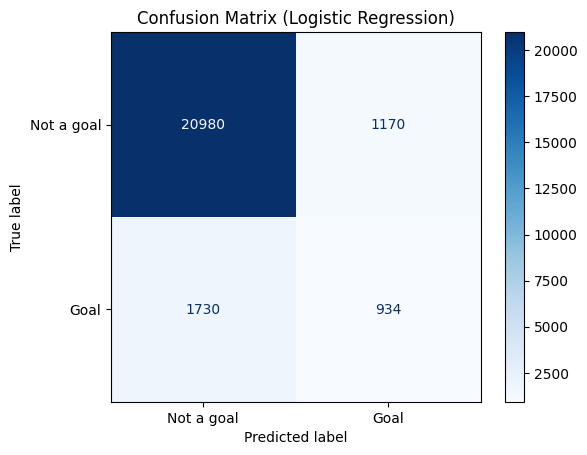


Logistic Regression
Accuracy: 0.8831304908519384
Precision: 0.4439163498098859
Recall: 0.3506006006006006
F1: 0.39177852348993286


In [680]:
X_train, X_test, y_train, y_test = preprocess_classifier(X, y2)
lor_xg = logistic_regression()

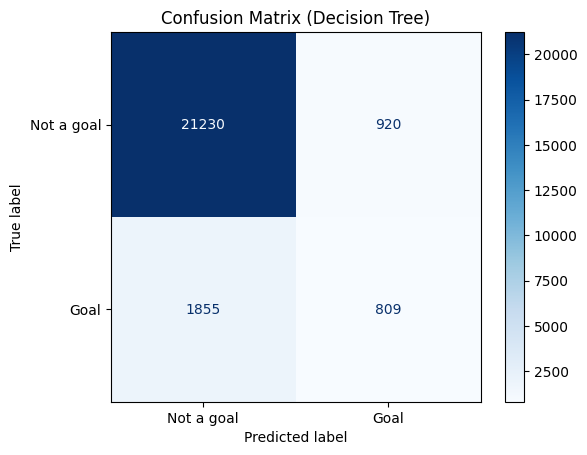


Decision Tree
Accuracy: 0.8881679696945273
Precision: 0.46790052053209946
Recall: 0.3036786786786787
F1: 0.3683132255861598


In [681]:
dt_xg, viz = decision_tree()

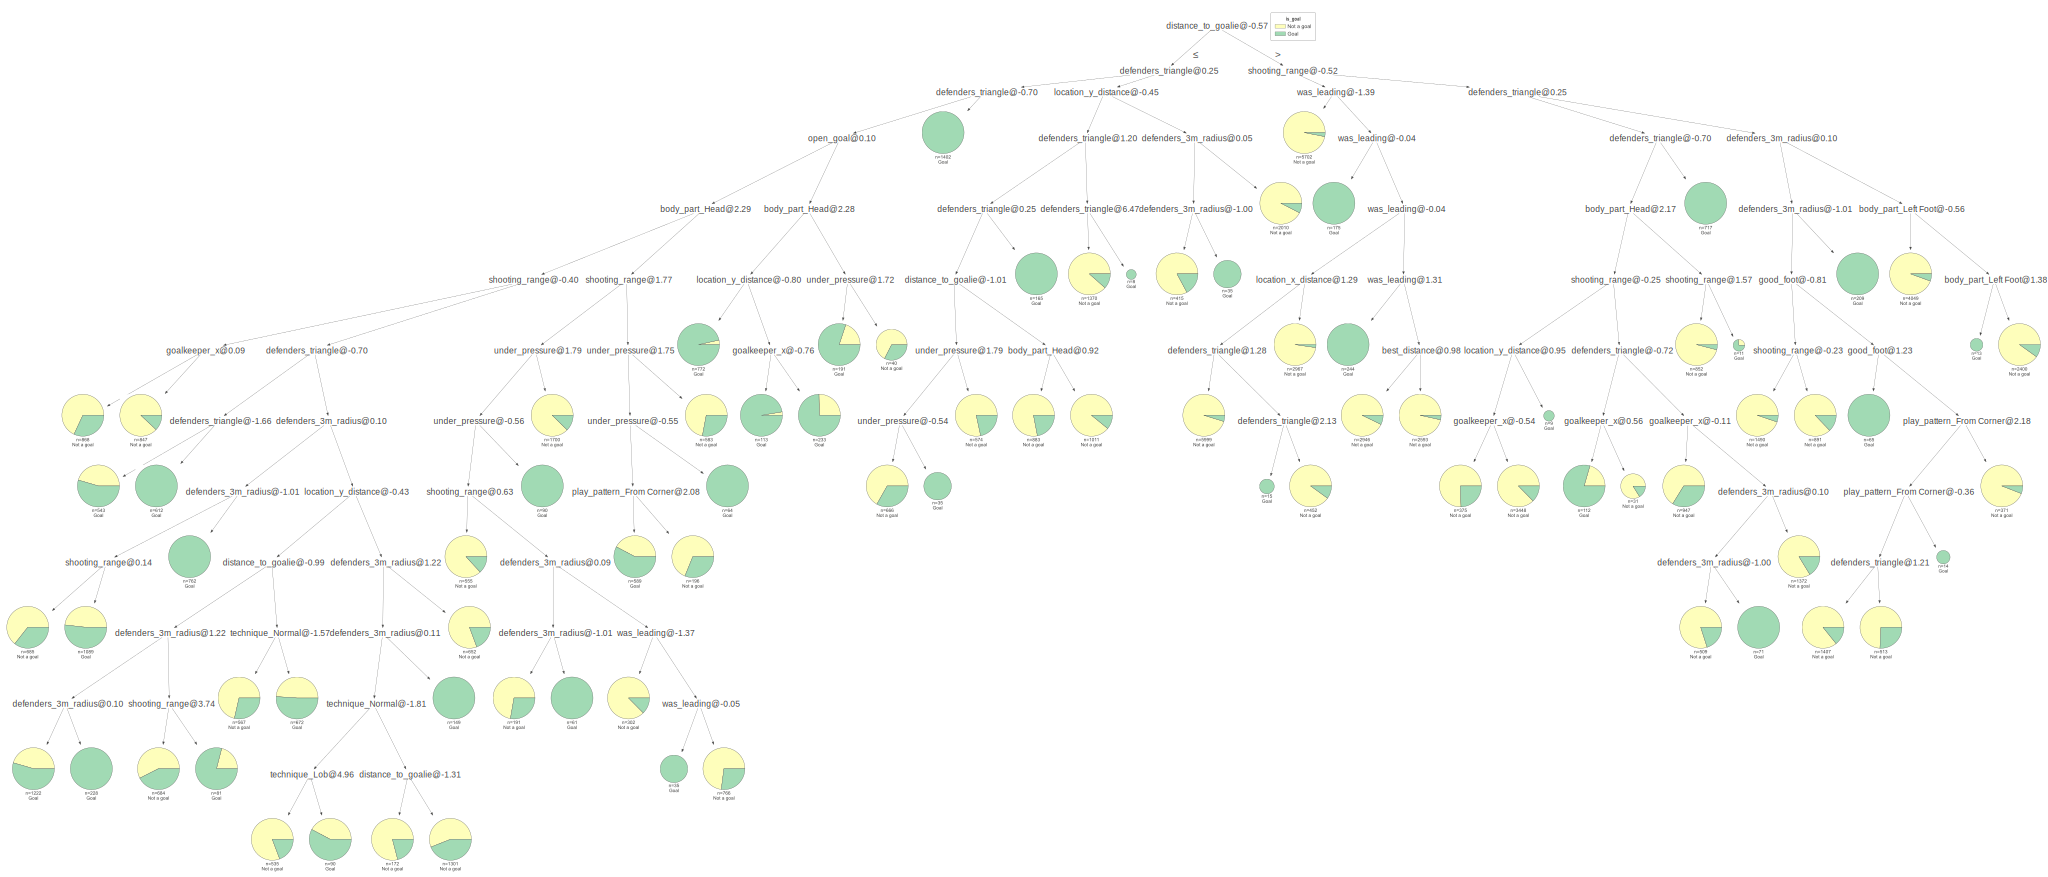

In [682]:
viz.view(fancy=False)

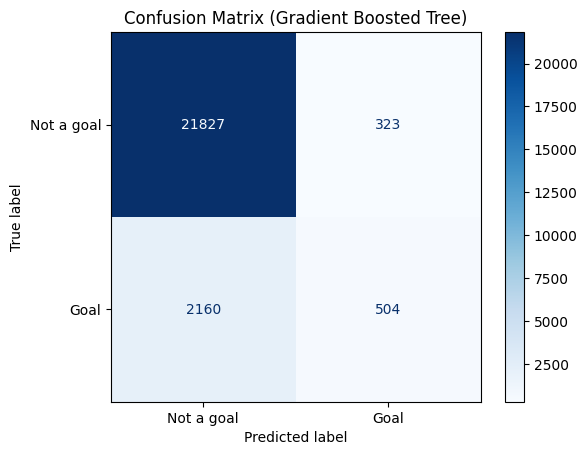


Gradient Boosted Tree
Accuracy: 0.8999355202708149
Precision: 0.6094316807738815
Recall: 0.1891891891891892
F1: 0.28874248066456604


In [683]:
gbt_xg = gradient_boosted_tree()

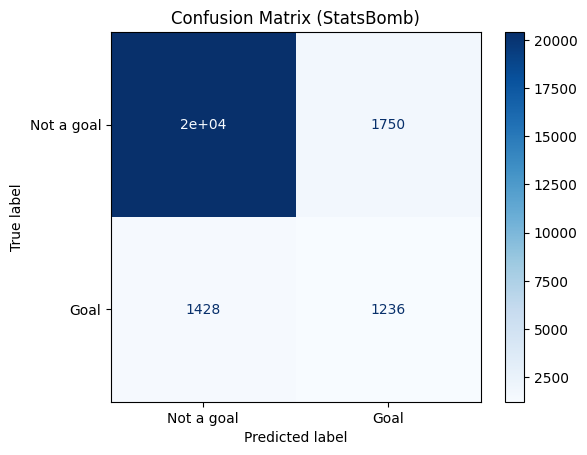


StatsBomb
Accuracy: 0.8719271379060208
Precision: 0.41393168117883455
Recall: 0.46396396396396394
F1: 0.4375221238938053


In [684]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
_, X_temp, _, sb_xg = preprocess_continuous(X, y1)
sb_pred = sb_xg.apply(lambda x: math.ceil(x-0.20))
calculate_stats(y_test, sb_pred, "StatsBomb")

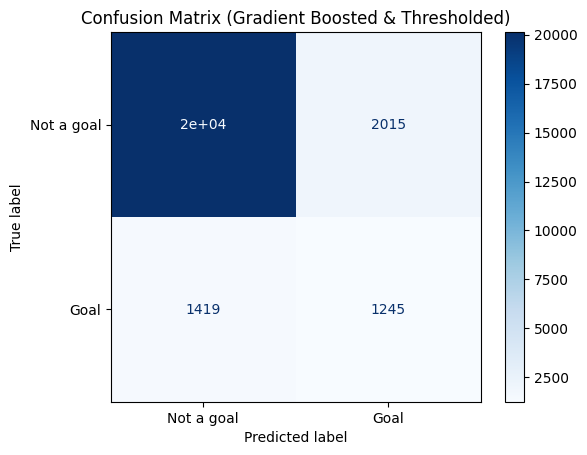


Gradient Boosted & Thresholded
Accuracy: 0.8616103812363988
Precision: 0.38190184049079756
Recall: 0.46734234234234234
F1: 0.42032410533423364


In [685]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
gbt_pred = [math.ceil(x[1]-0.24) for x in gbt_xg]
calculate_stats(y_test, gbt_pred, "Gradient Boosted & Thresholded")

In [686]:
df = pd.DataFrame({"lr_xg": lr_xg, "lor_xg": [x[1] for x in lor_xg], "dt_xg": [x[1] for x in dt_xg], "gbt_xg": [x[1] for x in gbt_xg], "sxg": sb_xg})
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lr_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lor_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["dt_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["gbt_xg"]), np.asarray(df["sxg"]))))

          0         1
0  1.000000  0.874908
1  0.874908  1.000000
          0         1
0  1.000000  0.877347
1  0.877347  1.000000
          0         1
0  1.000000  0.837298
1  0.837298  1.000000
          0         1
0  1.000000  0.875382
1  0.875382  1.000000


In [687]:
diff = gbt_pred - y_test
data_copy.iloc[diff[diff == -1].index].sort_values(by=["statsbomb_xg"])

,period,minute,possession,duration,season_id,match_id,timestamp,team,play_pattern,position,...,statsbomb_xg,end_location_x,end_location_y,is_goal,shot_angle,good_foot,shots_so_far,xg_so_far,game_state,was_leading
50941,1.0,20.0,33.0,2.422462,2015/2016,3829448.0,00:20:01.790,Stade de Reims,From Corner,Center Attacking Midfield,...,0.006140,120.0,42.9,True,1.124885,True,4,0.493165,0.0,0
79644,1.0,27.0,62.0,2.827583,2015/2016,3901151.0,00:27:25.096,Lille,From Free Kick,Center Attacking Midfield,...,0.006430,120.0,43.4,True,1.088283,True,3,0.262192,0.0,0
76190,1.0,30.0,75.0,2.684794,2015/2016,3900495.0,00:30:24.028,Bastia,From Free Kick,Center Attacking Midfield,...,0.006633,120.0,43.3,True,0.733439,True,9,0.565284,0.0,0
24725,2.0,89.0,191.0,0.937964,2015/2016,3754050.0,00:44:55.244,Sunderland,From Free Kick,Left Center Forward,...,0.006759,119.9,37.8,True,-1.164378,False,17,0.751779,-1.0,-1
36468,1.0,6.0,12.0,2.540855,2020/2021,3775649.0,00:06:43.784,West Ham United LFC,Regular Play,Right Wing,...,0.007074,120.0,36.9,True,-0.948764,False,3,0.237255,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50488,2.0,92.0,167.0,0.353616,2015/2016,3829427.0,00:47:24.256,Troyes,From Free Kick,Center Defensive Midfield,...,0.611486,120.0,43.2,True,1.030377,False,9,0.687340,-1.0,-1
46640,2.0,48.0,107.0,0.811193,2015/2016,3825766.0,00:03:38.971,Real Betis,Regular Play,Left Center Forward,...,0.623726,120.0,39.3,True,-0.112427,False,0,0.000000,0.0,0
19965,1.0,39.0,78.0,0.902098,2019/2020,2275072.0,00:39:25.907,Chelsea FCW,Regular Play,Center Forward,...,0.642794,120.0,42.0,True,-0.304875,False,23,3.886211,1.0,1
42604,2.0,89.0,169.0,0.444034,2015/2016,3825598.0,00:44:22.981,Atlético Madrid,Regular Play,Right Midfield,...,0.655127,120.0,42.8,True,0.419880,False,10,0.438424,1.0,1


In [688]:
diff_sb = sb_pred - y_test
data_copy.iloc[diff_sb[diff_sb == -1].index].sort_values(by=["statsbomb_xg"])

,period,minute,possession,duration,season_id,match_id,timestamp,team,play_pattern,position,...,statsbomb_xg,end_location_x,end_location_y,is_goal,shot_angle,good_foot,shots_so_far,xg_so_far,game_state,was_leading
75341,1.0,3.0,10.0,2.117102,2023,3893807.0,00:03:35.731,Republic of Ireland Women's,From Corner,Left Wing Back,...,0.000180,120.0,37.2,True,-1.582588,True,2,0.449885,0.0,0
36574,2.0,77.0,162.0,1.379908,2020/2021,3775652.0,00:32:17.726,Brighton & Hove Albion WFC,From Corner,Left Defensive Midfield,...,0.000180,120.0,38.2,True,1.573442,True,3,0.315172,0.0,0
9678,2.0,82.0,191.0,2.091759,2019,68357.0,00:37:50.104,Australia Women's,From Corner,Left Back,...,0.000180,120.0,38.4,True,-1.558631,True,18,3.469805,-4.0,-1
38917,1.0,37.0,79.0,2.096292,2021/2022,3813271.0,00:37:23.729,Goa,From Corner,Right Defensive Midfield,...,0.000180,120.0,40.2,True,-1.570796,True,16,0.776227,-1.0,-1
50941,1.0,20.0,33.0,2.422462,2015/2016,3829448.0,00:20:01.790,Stade de Reims,From Corner,Center Attacking Midfield,...,0.006140,120.0,42.9,True,1.124885,True,4,0.493165,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38169,2.0,91.0,182.0,0.546392,2021/2022,3802685.0,00:46:23.391,Paris Saint-Germain,From Free Kick,Right Center Midfield,...,0.199503,120.0,36.6,True,-0.527146,False,10,1.384874,-1.0,-1
11034,1.0,30.0,76.0,0.904046,2008/2009,69185.0,00:30:01.508,Barcelona,Regular Play,Right Wing,...,0.199767,120.0,43.7,True,0.905507,False,9,1.528228,1.0,1
45507,1.0,15.0,35.0,0.816447,2015/2016,3825718.0,00:15:56.459,Real Madrid,From Throw In,Center Forward,...,0.199854,120.0,37.6,True,-0.307046,False,9,0.545332,0.0,0
17949,2.0,79.0,166.0,0.700376,2016/2017,267395.0,00:34:10.879,Barcelona,Regular Play,Right Back,...,0.199916,120.0,37.0,True,-0.605111,False,17,2.337868,4.0,1


In [689]:
_, data_copy_test, _, gbt_xg_test = train_test_split(data_copy[data_copy["is_penalty"] == False], y2, test_size=0.3, random_state=20)
diff_xg = [x[1] for x in gbt_xg] - sb_xg
data_copy_test["diff"] = diff_xg
data_copy_test["gbt_xg"] = [x[1] for x in gbt_xg]
data_copy_test["sb_xg"] = sb_xg
data_copy_test.sort_values(by=["diff"])

,period,minute,possession,duration,season_id,match_id,timestamp,team,play_pattern,position,...,is_goal,shot_angle,good_foot,shots_so_far,xg_so_far,game_state,was_leading,diff,gbt_xg,sb_xg
75553,1.0,45.0,86.0,0.338997,2023,3893814.0,00:45:40.325,Sweden Women's,Regular Play,Center Forward,...,True,0.049958,True,18,2.430125,3.0,1,-0.532787,0.155049,0.687836
46640,2.0,48.0,107.0,0.811193,2015/2016,3825766.0,00:03:38.971,Real Betis,Regular Play,Left Center Forward,...,True,-0.112427,False,0,0.000000,0.0,0,-0.463912,0.159814,0.623726
44015,2.0,45.0,97.0,1.082024,2015/2016,3825654.0,00:00:29.438,Valencia,Regular Play,Center Forward,...,True,-0.458697,True,0,0.000000,0.0,0,-0.461471,0.121808,0.583280
69176,2.0,77.0,166.0,0.983170,2015/2016,3890343.0,00:32:15.971,Hertha Berlin,Regular Play,Center Attacking Midfield,...,False,0.135997,False,3,0.103904,1.0,1,-0.445437,0.266600,0.712037
42604,2.0,89.0,169.0,0.444034,2015/2016,3825598.0,00:44:22.981,Atlético Madrid,Regular Play,Right Midfield,...,True,0.419880,False,10,0.438424,1.0,1,-0.442512,0.212615,0.655127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50237,1.0,41.0,87.0,1.399890,2015/2016,3829416.0,00:41:45.136,OGC Nice,From Free Kick,Center Attacking Midfield,...,False,-1.281181,True,4,0.326945,-1.0,-1,0.683301,0.689786,0.006486
20514,2.0,90.0,182.0,0.240466,2019/2020,2275096.0,00:45:13.649,West Ham United LFC,From Free Kick,Right Center Forward,...,False,-0.170212,False,9,0.646741,-1.0,-1,0.689881,0.812452,0.122571
9678,2.0,82.0,191.0,2.091759,2019,68357.0,00:37:50.104,Australia Women's,From Corner,Left Back,...,True,-1.558631,True,18,3.469805,-4.0,-1,0.833866,0.834046,0.000180
54793,1.0,32.0,57.0,1.464773,2022,3857264.0,00:32:17.089,Argentina,From Corner,Right Wing,...,False,-1.573394,True,15,1.311217,2.0,1,0.838760,0.838940,0.000180


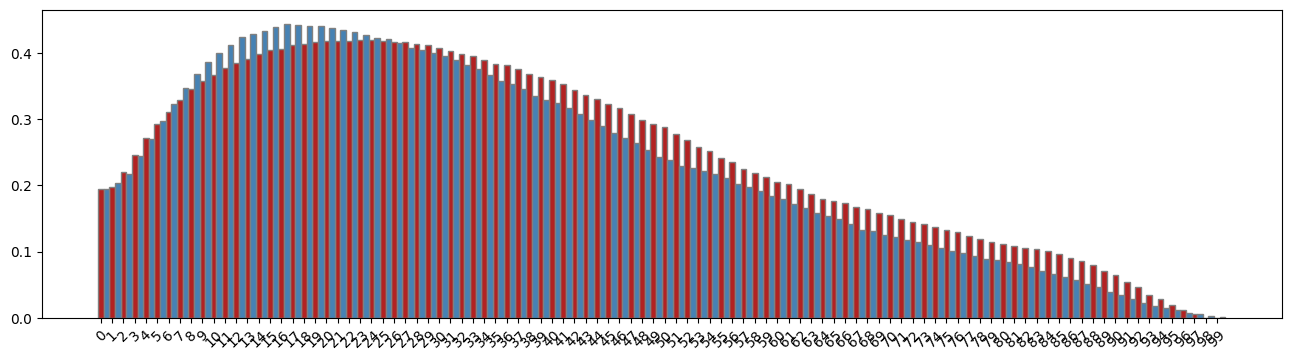

In [690]:
my_f1_scores = []
sb_f1_scores = []
for threshold in range(0, 100):
    gbt_pred = [math.ceil(x[1]-(threshold/100)) for x in gbt_xg]
    sb_pred = [math.ceil(x-(threshold/100)) for x in sb_xg]
    my_f1 = f1_score(y_test, gbt_pred)
    sb_f1 = f1_score(y_test, sb_pred)
    my_f1_scores.append(my_f1)
    sb_f1_scores.append(sb_f1)

barWidth = 0.5
r1 = np.arange(len(my_f1_scores))
r2 = [x + barWidth for x in r1]

plt.rcParams["font.size"] = 10
plt.rcParams["font.stretch"] = "semi-condensed"
plt.rcParams['grid.color'] = 'grey'

plt.figure(figsize=(16,4))
plt.bar(r1, pd.Series(my_f1_scores), color="firebrick", width=barWidth, edgecolor='grey', label='Our Prediction')
plt.bar(r2, pd.Series(sb_f1_scores), color="steelblue", width=barWidth, edgecolor='grey', label='SB Prediction')

plt.xticks(r1, [x for x in range(0, 100)], rotation=45)
plt.show()